In [88]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from sklearn import svm,tree
from sklearn.externals.six import StringIO  
import pydot

# Functions

In [89]:
RanDomState=1000
def bool_attack(count):
    if count>0:
        return 1
    else:
        return 0

# Version 1 : Area compute grid

In [66]:
df = pd.read_csv('../data/aden_golfe_matrix_area.csv',sep=';')
df[df["count"]>0].head()

,Month,Years,count,lat_area,lon_area
73,2,2008,2,2,12
116,3,2008,1,2,11
117,3,2008,1,3,11
122,3,2008,1,1,13
157,4,2008,1,2,9


## Pre-traitement

### Attack column

On créé une colonne pour savoir si il y a une attaque ou non.

In [4]:
df['attack'] = df.apply(lambda row: bool_attack(row['count']), axis=1)

### Binary

Le but de ce paragraphe est de transformer les colonnes "lat_area" et "lon_area" en colonnes binaire, c'est à dire de créer autant de colonnes que d'observations possibles

On créer les colonnes vides

In [5]:
feature_dyna=[]

latUnique=np.sort(df['lat_area'].unique())
print latUnique
for i in range(0,len(latUnique)):
    nameColLat='lat_area_'+str(latUnique[i])
    #print nameColLat
    df[nameColLat]=0
    feature_dyna.append(nameColLat)
    
lonUnique=np.sort(df['lon_area'].unique())
print lonUnique
for i in range(0,len(lonUnique)):
    nameColLon='lon_area_'+str(lonUnique[i])
    #print nameColLon
    df[nameColLon]=0
    feature_dyna.append(nameColLon)

[0 1 2 3 4 5]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


On remplit ensuite les colonnes 'lat_area_ ...' et 'lon_area_ ...'

In [6]:
for index, row in df.iterrows():
    df.set_value(index, "lat_area_"+str(row['lat_area']),1)
    df.set_value(index, "lon_area_"+str(row['lon_area']),1)
         
df.head()

,Month,Years,count,lat_area,lon_area,attack,lat_area_0,lat_area_1,lat_area_2,lat_area_3,...,lon_area_8,lon_area_9,lon_area_10,lon_area_11,lon_area_12,lon_area_13,lon_area_14,lon_area_15,lon_area_16,lon_area_17
0,1,2008,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2008,0,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2008,0,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2008,0,3,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2008,0,4,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
globalfeatures=['Month','Years']

features=np.concatenate([np.asarray(feature_dyna),globalfeatures])
features2=np.concatenate([globalfeatures,['lat_area','lon_area']])

target='attack'

# Sampling 

In [8]:
Sampling=True

if Sampling:
    df_attack_raw = df[df[target] == 1]
    df_non_attack_raw = df[df[target] == 0]
    percentage = len(df_attack_raw)/float(len(df_non_attack_raw))
    print "pourcentage de ligne comportant des attaques : "+str(percentage*100)
    df_non_attack=df.sample(frac=percentage, random_state=RanDomState)
    print str(len(df_non_attack))+'/'+str(len(df_non_attack_raw))

    DfSampling=df_non_attack.append(df_attack_raw)
    print len(DfSampling)
    
else:
    DfSampling=df

pourcentage de ligne comportant des attaques : 7.8125
302/3584
582


# Algorithme de machine learning

## Séparation des jeux de données

On définit un jeu de données pour entrainer notre modèle et un jeu de données pour tester et évaluer notre modèle.

In [22]:
years_prediction=2011
dfTrain=DfSampling[DfSampling['Years']<years_prediction]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]


print "Année à prédire : "+str(years_prediction)
print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['count']!=0]))+'/'+str(len(dfTest))

Année à prédire : 2011
 
Entrainement : Nombre d'attaques /nombre de ligne : 205/330
Test : Nombre d'attaques /nombre de ligne : 64/93


## Random forest

On définit les colonnes pour prédire les attaques.

In [23]:
forest = RandomForestClassifier(random_state=1,n_estimators=20)
forest=forest.fit(dfTrain[features], dfTrain[target])

predictions=forest.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['count']!=0]))

print "Pourcentage de précision : "+str(forest.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 55/64
Pourcentage de précision : 0.645161290323


In [24]:
#print pd.crosstab(dfTest[target],predictions, colnames=['preds'])
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
attack,,
0,0.586207,0.413793
1,0.328125,0.671875


In [25]:
pd.crosstab(dfTest[target],predictions, colnames=['preds'])

preds,0,1
attack,,
0,17,12
1,21,43


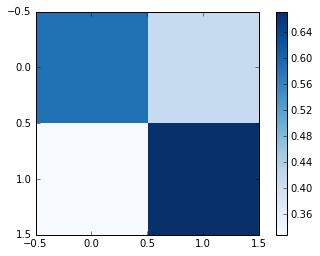

In [26]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Compare area

In [13]:
dfTest['prediction']=predictions
Compare=dfTest[(dfTest[target]!=0) | (dfTest['prediction']!=0)].sort(['Years','Month','lat_area','lon_area'])
Compare[['Month','Years','lat_area','lon_area','attack','prediction']]

/Users/romainphilippe/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/romainphilippe/app/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Month,Years,lat_area,lon_area,attack,prediction
3949,1,2012,3,7,1,1
3971,1,2012,4,16,1,1
3945,1,2012,5,5,1,1
4014,1,2012,5,28,1,1
4029,2,2012,3,6,1,1
4026,2,2012,4,5,1,1
4026,2,2012,4,5,1,1
4030,2,2012,4,6,1,1
4062,2,2012,5,18,1,1
4091,2,2012,7,26,1,1


# Boosting 

In [571]:


boos = GradientBoostingClassifier(random_state=1,n_estimators=100,max_depth=10)
boos=boos.fit(dfTrain[features], dfTrain[target])

predictionsBoos=boos.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictionsBoos.sum())+'/'+str(len(dfTest[dfTest['count']!=0]))

print "Pourcentage de précision : "+str(boos.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictionsBoos)

Nombre d'attaques prévus/Nombre d'attaques réel: 51/25
Pourcentage de précision : 0.538461538462


In [626]:
#print pd.crosstab(dfTest[target],predictions, colnames=['preds'])
pd.crosstab(dfTest[target],predictionsBoos, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

ValueError: array length 78 does not match index length 59

# Version 2 : Area compute by hand

In [96]:
dfAreaHand = pd.read_csv('../data/aden_golfe_matrix_area_hand.csv',sep=';')
dfAreaHand[dfAreaHand["Count"]>0].head()

,Area,Count,Fortnight,Month,Type,Years,Activity
192,K,1,1,2,Tanker,2008,2
218,K,1,1,2,Tug,2008,2
386,J,1,2,3,Tanker,2008,2
439,K,1,2,3,Vehicle Carrier,2008,2
467,M,1,2,3,Vessel,2008,2


## Pre-traitement

### Attack column

On créé une colonne pour savoir si il y a une attaque ou non.

In [97]:
dfAreaHand['Attack'] = dfAreaHand.apply(lambda row: bool_attack(row['Count']), axis=1)

### Binary

Le but de ce paragraphe est de transformer la colonne "Area" en colonnes binaire, c'est à dire de créer autant de colonnes que d'observations possibles

In [98]:
uniqueArea=dfAreaHand["Area"].unique()
uniqueType=dfAreaHand["Type"].unique()
print uniqueArea
print uniqueType

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M']
['Tanker' 'Tug' 'Vehicle Carrier' 'Vessel' 'Other' 'Barge'
 'Offshore Exploitation']


In [99]:
dfAreaHand["Area"] = dfAreaHand["Area"].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13}).astype(int)
dfAreaHand["Type"] = dfAreaHand["Type"].map({'Vehicle Carrier': 1, 'Tanker': 2, 'Offshore Exploitation': 3, 'Other': 4, 'Tug': 5,'Vessel': 6, 'Barge': 7}).astype(int)
dfAreaHand.head()

,Area,Count,Fortnight,Month,Type,Years,Activity,Attack
0,1,0,1,1,2,2008,2,0
1,2,0,1,1,2,2008,2,0
2,3,0,1,1,2,2008,2,0
3,4,0,1,1,2,2008,2,0
4,5,0,1,1,2,2008,2,0


In [100]:
features=['Activity','Fortnight','Month','Type','Area','Years']
target='Attack'

### Sampling 

In [101]:
Sampling=True

if Sampling:
    df_attack_raw = dfAreaHand[dfAreaHand[target] == 1]
    df_non_attack_raw = dfAreaHand[dfAreaHand[target] == 0]
    percentage = len(df_attack_raw)/float(len(df_non_attack_raw))
    print "pourcentage de ligne comportant des attaques : "+str(percentage*100)
    df_non_attack=dfAreaHand.sample(frac=percentage, random_state=1000)
    print str(len(df_non_attack))+'/'+str(len(df_non_attack_raw))

    DfSampling=df_non_attack.append(df_attack_raw)
    print len(DfSampling)
else:
    DfSampling=dfAreaHand

pourcentage de ligne comportant des attaques : 2.37042989152
362/14934
716


## Machine learning

### Séparation des jeux de données

On définit un jeu de données pour entrainer notre modèle et un jeu de données pour tester et évaluer notre modèle.

In [137]:
years_prediction=2009
dfTrain=DfSampling[DfSampling['Years']<years_prediction]
dfTest=DfSampling[(DfSampling['Years']==years_prediction)]


#dfTrain, dfTest = train_test_split(DfSampling, test_size=0.20, random_state=RanDomState)

print " "
print "Entrainement : Nombre d'attaques /nombre de ligne : "+str(len(dfTrain[dfTrain['Count']!=0]))+'/'+str(len(dfTrain))
print "Test : Nombre d'attaques /nombre de ligne : "+str(len(dfTest[dfTest['Count']!=0]))+'/'+str(len(dfTest))

 
Entrainement : Nombre d'attaques /nombre de ligne : 72/113
Test : Nombre d'attaques /nombre de ligne : 96/153


### Random forest

In [138]:
forest = GradientBoostingClassifier(random_state=1)
forest=forest.fit(dfTrain[features], dfTrain[target])

predictions=forest.predict(dfTest[features])
print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))

print "Pourcentage de précision : "+str(forest.score(dfTest[features], dfTest[target]))
cm = confusion_matrix(dfTest[target], predictions)

Nombre d'attaques prévus/Nombre d'attaques réel: 69/96
Pourcentage de précision : 0.666666666667


In [139]:
pd.crosstab(dfTest[target],predictions, colnames=['preds']).apply(lambda r: r/r.sum(), axis=1)

preds,0,1
Attack,,
0,0.789474,0.210526
1,0.406250,0.593750


In [136]:
pd.crosstab(dfTest[target],predictions, colnames=['preds'])

preds,0,1
Attack,,
0,34,18
1,4,24


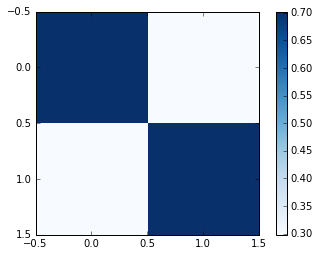

In [120]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

In [61]:
score=0
for i in (2009,2010,2011,2012,2013,2014):
    print "----------------------------------------------------------"
    print i
    dfTrain=DfSampling[DfSampling['Years']<i]
    dfTest=DfSampling[(DfSampling['Years']==i)]
    forest = GradientBoostingClassifier(random_state=1)
    forest=forest.fit(dfTrain[features], dfTrain[target])

    predictions=forest.predict(dfTest[features])
    print "Nombre d'attaques prévus/Nombre d'attaques réel: "+str(predictions.sum())+'/'+str(len(dfTest[dfTest['Count']!=0]))
    currentScore=forest.score(dfTest[features], dfTest[target])
    score=score+currentScore
    print "Pourcentage de précision : "+str(currentScore)
print score

----------------------------------------------------------
2009


KeyError: 'Years'